### Podatkovno rudarjenje. Projektna naloga 3. 6. 2018

## PREDIKCIJA OKUŽENOSTI Z VIRUSOM ZAHODNEGA NILA

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cbook as cbook
%matplotlib inline
#nevidim problema
import pandas_profiling as pdp
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from IPython.display import Image

**Funkcije**

In [2]:
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)
    
def clean_col(column):
    weather[column] = weather[column].str.replace('T','0.005')
    weather[column] = weather[column].str.replace('M','0.0')
    weather[column] = weather[column].astype(float)

**Nalaganje podatkov**

In [3]:
#nalozi mapo
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")
#nalozi ostalo
data=pd.read_csv('../input/train.csv')
weather=pd.read_csv('../input/weather.csv')
spray=pd.read_csv('../input/spray.csv')
#pregled osnovnega podatkovnega okvirja
data.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


**Urejanje osnovnih podatkov** zbrišemo nepomembna polja kot so Adress, Block, Street,AddressNumberAndStreet,AdressAccuracy saj ta polja na več načinov opisujejo isto stvar le, da v neuporabnem formatu

In [4]:
data = data[['Trap','Latitude','Longitude','Date','Species','WnvPresent','NumMosquitos']].groupby([
            'Trap','Latitude','Longitude','Date', 'Species','WnvPresent']).agg({'NumMosquitos':np.sum}).reset_index()
data.Date = pd.to_datetime(data.Date)
data['year']  = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day']   = data['Date'].dt.day
data=data.sort_values("Date")
data.Date = pd.to_datetime(data.Date)
data.head()

,Trap,Latitude,Longitude,Date,Species,WnvPresent,NumMosquitos,year,month,day
2061,T046,41.891118,-87.654491,2007-05-29,CULEX RESTUANS,0,1,2007,5,29
5304,T129,41.891126,-87.611560,2007-05-29,CULEX PIPIENS/RESTUANS,0,1,2007,5,29
5305,T129,41.891126,-87.611560,2007-05-29,CULEX RESTUANS,0,2,2007,5,29
4601,T096,41.731922,-87.677512,2007-05-29,CULEX RESTUANS,0,5,2007,5,29
4600,T096,41.731922,-87.677512,2007-05-29,CULEX PIPIENS,0,1,2007,5,29


**Podatkovni tipi so že urejeni**

In [5]:
data.dtypes

Trap                    object
Latitude               float64
Longitude              float64
Date            datetime64[ns]
Species                 object
WnvPresent               int64
NumMosquitos             int64
year                     int64
month                    int64
day                      int64
dtype: object

In [6]:
data.year.unique()

array([2007, 2009, 2011, 2013], dtype=int64)

**Vizualizacija mesta in nastavljenih pasti za komarje**
Slika predstavlja mesta na katerih so postavljene pasti v mestu Chikago. Te pasti so sredstvo vseh mojih podarkov o komarjih saj vsaka dnevno zbira podatke o vrsti in šrevilu posameznih komarjev ujetih v posamezno past ti komarji so tudi testirani za prisotnost virusa.

In [7]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

dataC=data[data.WnvPresent==0]
datai=data[data.WnvPresent==1]

y2007=dataC[dataC.year==2007]
y2009=dataC[dataC.year==2009]
y2011=dataC[dataC.year==2011]
y2013=dataC[dataC.year==2013]

iy2007=datai[datai.year==2007]
iy2009=datai[datai.year==2009]
iy2011=datai[datai.year==2011]
iy2013=datai[datai.year==2013]

**Vizualizacija mesta in nastavljenih pasti za komarje**
**vizualizacije mest pasti in kiličina komarjev ki so bili v njih ujeti skozi leta**
**vizualizaciji razmirja pogostosti pojavitve virusa**
spodanja vizualizacij

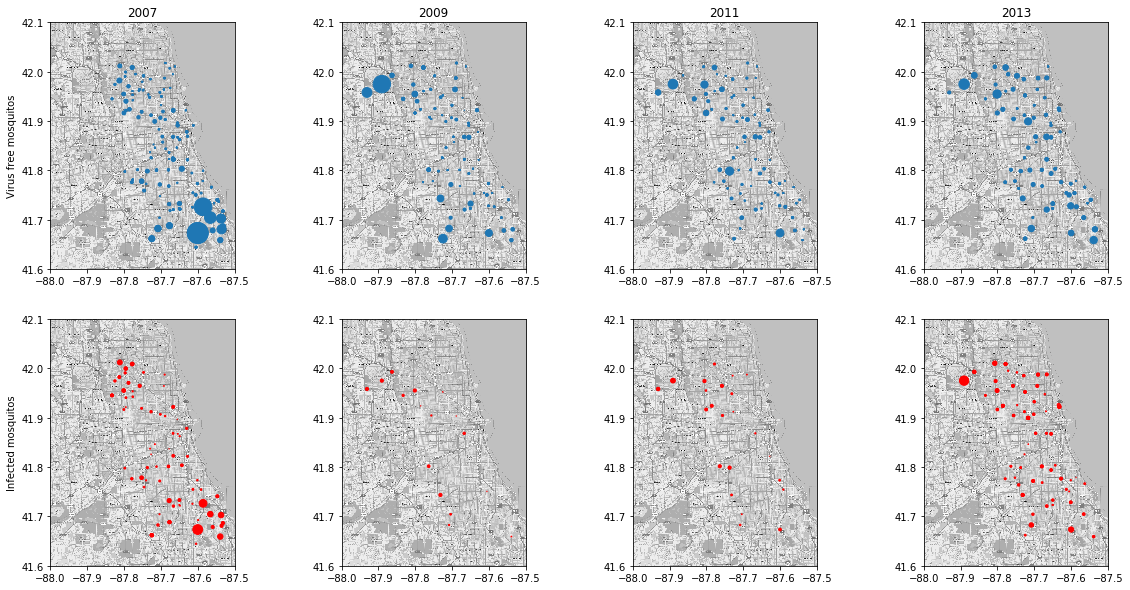

In [8]:
interp = 'bilinear'
fig, axs = plt.subplots(ncols=4,nrows=2, figsize=(20, 10))
axs[0,0].set_title('2007')
axs[0,0].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[0,0].scatter(x=y2007[['Longitude']], y=y2007[['Latitude']], s=y2007[['NumMosquitos']]/5)

axs[0,1].set_title('2009')
axs[0,1].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[0,1].scatter(x=y2009[['Longitude']], y=y2009[['Latitude']], s=y2009[['NumMosquitos']]/5)

axs[0,2].set_title('2011')
axs[0,2].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[0,2].scatter(x=y2011[['Longitude']], y=y2011[['Latitude']], s=y2011[['NumMosquitos']]/5)

axs[0,3].set_title('2013')
axs[0,3].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[0,3].scatter(x=y2013[['Longitude']], y=y2013[['Latitude']], s=y2013[['NumMosquitos']]/5)

axs[1,0].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[1,0].scatter(x=iy2007[['Longitude']], y=iy2007[['Latitude']], s=iy2007[['NumMosquitos']]/5 , c="r")

axs[1,1].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[1,1].scatter(x=iy2009[['Longitude']], y=iy2009[['Latitude']], s=iy2009[['NumMosquitos']]/5 ,c="r")

axs[1,2].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[1,2].scatter(x=iy2011[['Longitude']], y=iy2011[['Latitude']], s=iy2011[['NumMosquitos']]/5,c="r")

axs[1,3].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[1,3].scatter(x=iy2013[['Longitude']], y=iy2013[['Latitude']], s=iy2013[['NumMosquitos']]/5,c="r")

axs[0,0].set(ylabel='Virus free mosquitos')
axs[1,0].set(ylabel='Infected mosquitos')
plt.show()

**analiza podatkovnega okvirja za vreme**

**Pandas prfile reporta za vremenski podatkovni okvir nebom vključil zaradi same dolžine izpisa**

In [9]:
#pdp.ProfileReport(weather)

In [10]:
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


**Čiščenje vremenskega podatkovnega okvirja** kot je razvidno iz profile reporta so podatki za vreme zelo neurejeni imamo veliko spremenljivk ki so visoko krelirane,veliko spremenljivk ima tudi zajetno vrednost mankajočih vrednosti. Pojavijo se tudi konstantne spremenljivke in spremenljivke katerih prevladuje samo ena vrednost. Zato se pri čiščenju odločim za selekcijo ostale vrednosti pa prečistim. Postopek ponovim večkrat dokler ne pridem do zaključka da, sta edini potencialno uporabni spremenljivki povprečna temperatura in povprečna hitrost vetra.

In [11]:
weather.Date = pd.to_datetime(weather.Date)

# skip the numeric columns, because they can't contain the 'M' string# skip  
check_missing_values = ['Depart','Heat','Cool','Sunrise','Sunset','Depth','Water1','SnowFall', 'Tavg']
for col in weather[check_missing_values]:
    station_1 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==1)])
    print (col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].str.contains('\D')) & (weather.Station==2)])
    print (col + ' has ' + str(station_2) + ' missing values at station 2')
    print ('')
print('dataframe legth : ' +str(len(weather["Heat"])))

Depart has 1271 missing values at station 1
Depart has 1472 missing values at station 2

Heat has 0 missing values at station 1
Heat has 11 missing values at station 2

Cool has 1096 missing values at station 1
Cool has 1021 missing values at station 2

Sunrise has 0 missing values at station 1
Sunrise has 1472 missing values at station 2

Sunset has 0 missing values at station 1
Sunset has 1472 missing values at station 2

Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2

Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2

SnowFall has 1472 missing values at station 1
SnowFall has 1472 missing values at station 2

Tavg has 0 missing values at station 1
Tavg has 11 missing values at station 2

dataframe legth : 2944


In [12]:
weather = weather[weather.Station==1].drop('Station',axis=1)
clean_col('AvgSpeed')
clean_col('Tavg')
##nevidim problema
weather['Tavg'][weather.Tavg==0] = (weather.Tmin + weather.Tmax) / 2
weather = weather[['Date','Tavg','AvgSpeed']]

weather.columns

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Index(['Date', 'Tavg', 'AvgSpeed'], dtype='object')

**vizualizacijska analiza korelacije izbranih lastnosti za vremenski podatkovni okvir**

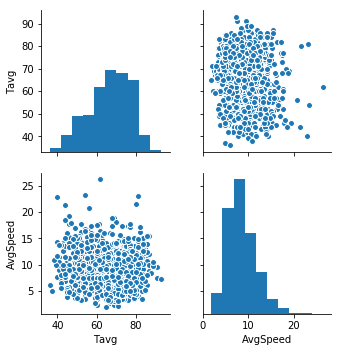

In [13]:
sns.pairplot(weather)

**Analiza podatkovnega okviraja za uporabo pesticidov**

In [14]:
spray.head(1)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163


In [15]:
spray.duplicated().sum()

541

In [16]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [17]:
spray.drop(["Time"],axis=1,inplace=True)
spray.drop_duplicates(inplace=True)
spray.head(1)

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163


**Vizualizacija za odkrivanje napak v podatkih**

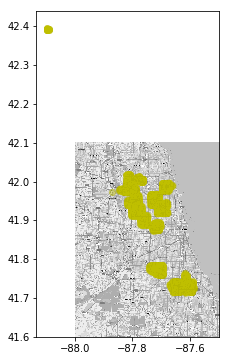

In [18]:
plt.figure(figsize=(5,6))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
#plt.scatter(x=spray[['Longitude']], y=spray[['Latitude']], c="y",alpha=0.1)
plt.scatter(x=spray.Longitude, y=spray.Latitude, c="y",alpha=0.1)

In [19]:
spray=spray[spray.Latitude<42.3]

**Korelacija uporabe pesticidov z pogostostjo pojavitve virusa**

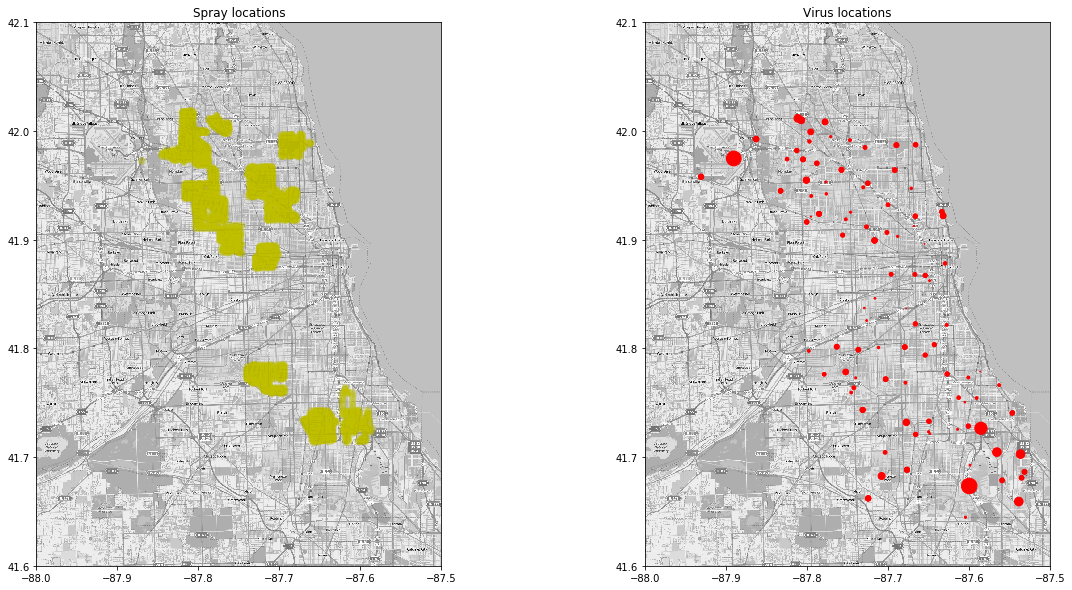

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
axs[0].set_title('Spray locations')
axs[0].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[0].scatter(x=spray[['Longitude']], y=spray[['Latitude']], c="y",alpha=0.1)

axs[1].set_title('Virus locations')
axs[1].imshow(mapdata,cmap=plt.get_cmap('gray'),extent=lon_lat_box,aspect=aspect)
axs[1].scatter(x=datai[['Longitude']], y=datai[['Latitude']], s=datai[['NumMosquitos']]/2, c="r")
plt.show()

**Analiza uravnoteženosti podatkov za predikcijo**

In [21]:
data.WnvPresent.value_counts()

0    8153
1     457
Name: WnvPresent, dtype: int64

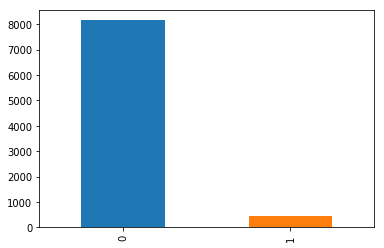

In [22]:
data.WnvPresent.value_counts().plot(kind="bar")

In [23]:
(9955-551)/9955

0.9446509291813159

**podatki so skrajno skrivljeni** večinski klasifikator nam da verjetnost 0.95% da komar ni okužen torej bo za naš problem mira clasifikacijske točnosti dokaj neuporabna. Zato se zaradi praktične zasnovanosti problema naeravam problem ocenjevati glede na priklic in preciznost saj je napaka neprimerno manjša če ocenimo, da je neokužen komar okužen kot pa obratno.

**IZBRANA MERA ZA OCENJEVANJE: POVRŠINA POD ROC KRIVULJO**

**Analiza podatkov o komarjih**

In [24]:
data.Species.value_counts()

CULEX PIPIENS/RESTUANS    3899
CULEX RESTUANS            2409
CULEX PIPIENS             1996
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

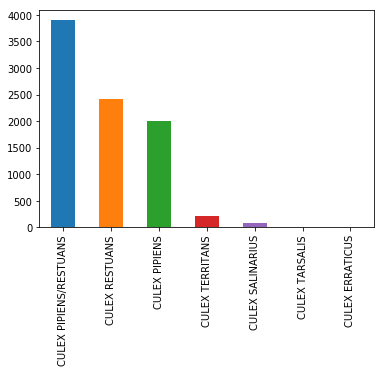

In [25]:
data.Species.value_counts().plot(kind="bar")

**razporeditev frekvence ujetih komarjev glede na vrsto**

In [26]:
a=data.groupby(["Species"])["Species"].count().reset_index(name='All')
b=data[data.WnvPresent==1].groupby("Species")["Species"].count().reset_index(name='Infected')
a=a.merge(b,on="Species",how="left")
a.fillna(int(0), inplace=True)
a.Infected=a.Infected.astype(int)
a["Ipr"]=(a["Infected"]/a["All"])*100
a

,Species,All,Infected,Ipr
0,CULEX ERRATICUS,1,0,0.000000
1,CULEX PIPIENS,1996,184,9.218437
2,CULEX PIPIENS/RESTUANS,3899,225,5.770710
3,CULEX RESTUANS,2409,48,1.992528
4,CULEX SALINARIUS,83,0,0.000000
5,CULEX TARSALIS,6,0,0.000000
6,CULEX TERRITANS,216,0,0.000000


**Prikaz verjetnosti, da je komar okužen glede na vrsto komarja** Iz vizualizacije je razvidno, da je verjetnost da je komar vrste  CULEX PIPENIS več kot 4 krat večja kot da je okužena najpogostejša vrsta komarja CULEX RESTUANS. Pri ostalih vrstah ni bilo zazanti okužbe vendar so ostale vrste zastopane v bistveno manjšem številu kar bi lahko bil razlog za takšne rezultate.

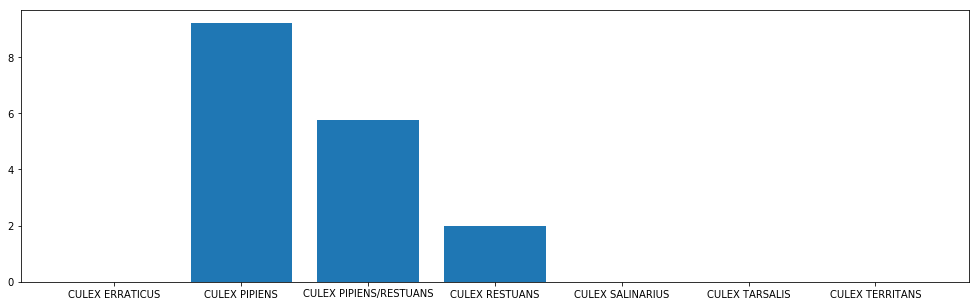

In [27]:
ind=np.arange(7)
plt.figure(figsize=(17, 5))
plt.bar(ind,tick_label=(a["Species"]),height=(a["Ipr"])) 
plt.show()

**Priprava podatkovnih okvirjev za predikcijo** združiti sem se odločil podatke za vreme in odatke ki poisujejo pasti. Podatke o pesticidih pa se nisem odločil vključiti ker uporaba pesticidov ni naključni parameter. Torej pridobleni vzorci nimajo napovedne moči za prihodnost.

In [28]:
data = pd.get_dummies(data, columns=['Species'])
train=data.merge(weather, on='Date')

In [29]:
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

**Čudne vrednosti v očiščenih podatkih** vrsta komarja culex reaticus se v podatkih pojavi le enkrat vsi primerki so neukuženi. Zaradi samo ene pojavitve več komarjev bi se lahko sklepalo da gre za napako v podatkih vendar vemo da je ta vrsta komarjev prisotna v chikagu in testna množica zahteva prisotnost te vrste komarja zato se ne odločim za odstranitev.

In [30]:
train[train.species_culex_erraticus==1]

,trap,latitude,longitude,date,wnvpresent,nummosquitos,year,month,day,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,tavg,avgspeed
8290,T900,41.974689,-87.890615,2013-09-06,0,7,2013,9,6,1,0,0,0,0,0,0,72.0,6.0


**Pandas prfile reporta za končnen testni podatkovni okvir nebom vključil zaradi same dolžine izpisa**

In [31]:
##pdp.ProfileReport(train)

**Izločanje neuporabnih oziroma nedovoljenih kolon** kolone kot so WnvPresent in NumMosquitos so neuporebne saj niso vsebovane v testnih podatkih iz kaggla. Datum služi samo za prekomerno prilagajane prav tako dan nima nikakoršne uporabne vrednosti. Leto sicer ima napovedno vrednost ampak podatke ko jih napovedujemo vsebujejo druge letnice tako da je tudi ta kolona neuporabna kar se tiče predikcije. Številka pasti se sicer zdi uporabna saj nekatere pasti ujamejo več komarjev kot druge, vendar se kot je vidno z vizualizacij popularnost posameznih pasti po letih močno spreminja zato je tudi ta atribut neuporaben.

In [32]:
# Get rid of features that we cannot use
features = train.columns.drop(['wnvpresent','nummosquitos','date','trap','year','day'])

X = train[features]
y = train.wnvpresent

X.to_csv('x.csv')
y.to_csv('y.csv')

**Prečno previrjanje**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

**Klasifikacija** zaključni del klasifikacjie sem se odločil narediti v orangu saj lahko tam dostopam do dločenih interaktivnih do katerih nimam dostopa preko jupyter notebooka

**klasifikacijsko drevo**

In [34]:
ct = tree.DecisionTreeClassifier()
ct_scores = cross_val_score(ct, X, y, cv=10, scoring='accuracy')
print(ct_scores)
print(ct_scores.mean())

[0.94315545 0.18909513 0.3712297  0.87224158 0.90360046 0.80371661
 0.31358885 0.55116279 0.34302326 0.31162791]
0.5602441734814246


**K najbljižjih sosedov**

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(knn_scores)
print(knn_scores.mean())

[0.94895592 0.39907193 0.29118329 0.94657375 0.93612079 0.82346109
 0.60278746 0.44418605 0.48372093 0.38604651]
0.6262107714693939


**Nevronska mreža**

In [36]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
nn_scores = cross_val_score(nn, X, y, cv=10, scoring='accuracy')
print(nn_scores)
print(nn_scores.mean())

[0.94663573 0.94663573 0.94663573 0.94657375 0.94657375 0.94657375
 0.94657375 0.94767442 0.94767442 0.94767442]
0.9469225454196559


**Ostale predikcije in vizualizacije naredim v orangu.** Orange se mi zdi dosti bol primeren za končne vizualizacije podatkov iz klasifikatorjev.

**Razultati iz oranga : **

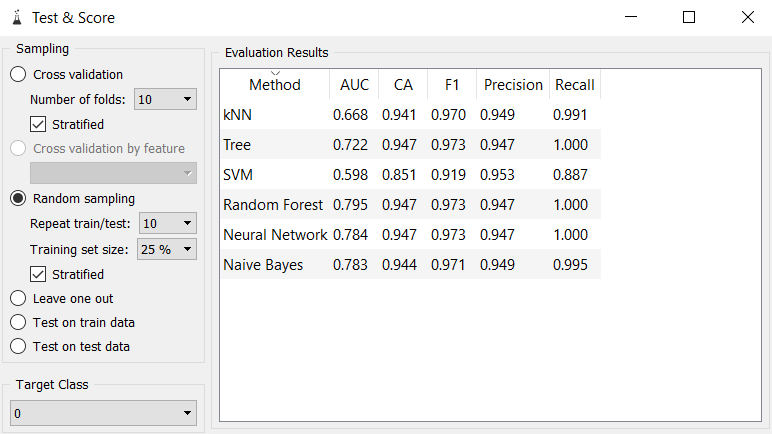

In [37]:
Image(filename="score2.png")

**Roc krivulje**

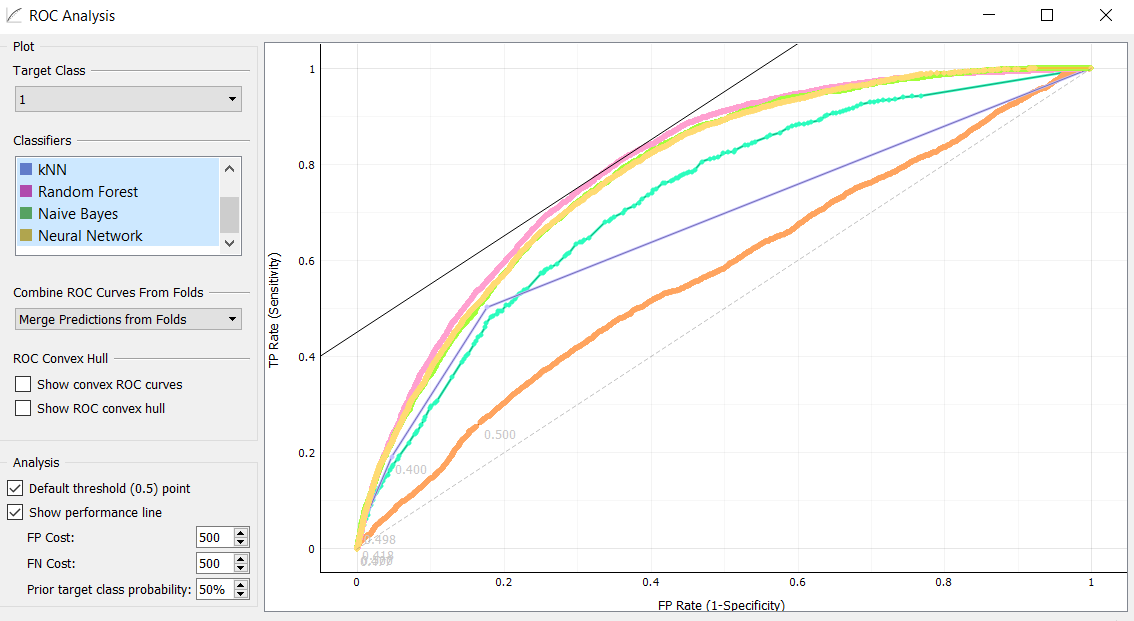

In [38]:
Image(filename="roc.png")

**primerjava mojih rezltatov z rezultati iz kaggla:** Moji modeli se predvidoma uvrstijo okoli 100 tega mesta. Kar je visoko v zgornji polovici od vseh 1306 tekmovalcev.

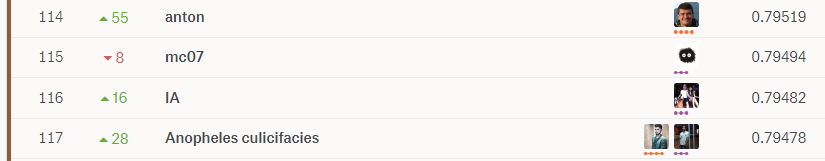

In [39]:
Image(filename="res.png")